# Predictive maintenance on Cable Joints
Within Alliander, challenges in operations are rising due to the energy transition. In order to facilitate Dutch electricity users, we have to not only work harder, but also smarter. Knowing when a cable will fail will help with plannability and research for electricity grid improvements. Sioux Technologies is supporting Alliander in this research, and for the first steps, we have developed a Object Oriented script to create a Circuit and Joint object.

## Loading classes
We have to load the separate classes for reading data files in this open-source repository. We also load some well-known packages for data loading.


In [1]:
import glob
import json
import os
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from alliander_predictive_maintenance.connection.circuit_weather_retriever.alliander_circuit_weather_retriever import \
    AllianderCircuitWeatherRetriever
from alliander_predictive_maintenance.connection.circuit_weather_retriever.alliander_weather_sources import \
    AllianderWeatherSources
from alliander_predictive_maintenance.connection.joints_with_partial_discharge_seasonality_reader.ijoints_with_partial_discharge_seasonality_reader import \
    IJointsWithPartialDischargeSeasonalityReader
from alliander_predictive_maintenance.connection.readers.circuit.circuit_factory import CircuitFactory
from alliander_predictive_maintenance.connection.readers.circuit.csv_circuit_config_storage import \
    CsvCircuitConfigStorage
from alliander_predictive_maintenance.connection.readers.circuit.csv_circuit_partial_discharge_storage import \
    CsvCircuitPartialDischargeStorage
from alliander_predictive_maintenance.connection.readers.circuit.excel_circuit_coordinates_reader import \
    ExcelCircuitCoordinateReader
from alliander_predictive_maintenance.connection.failed_joints_reader.excel_failed_joints_reader import \
    ExcelFailedJointsReader
from alliander_predictive_maintenance.connection.joints_with_partial_discharge_seasonality_reader.excel_joints_with_partial_discharge_seasonality_reader import \
    ExcelJointsWithPartialDischargeSeasonalityReader
from alliander_predictive_maintenance.conversion.data_types.time_window import TimeWindow
from alliander_predictive_maintenance.conversion.data_types.circuit_coordinate import CircuitCoordinate
from alliander_predictive_maintenance.connection.failed_joints_reader.ifailed_joints_reader import IFailedJointsReader

logging.basicConfig(level=logging.INFO)

## Loading data sets
We have to load data sets of circuit configuration, circuit partial discharge, a file of known failed joints, circuit coordinates (anonymised), and joints with partial discharge in a seasonal trend.

In [2]:
logging.info("Loading local storage files")
with open("../../config.json") as f:
    config = json.load(f)

csv_circuit_config_storage = CsvCircuitConfigStorage(
    Path(config["data"]["circuit_config_absolute_root_folder"]))
csv_circuit_partial_discharge_data_storage = CsvCircuitPartialDischargeStorage(
    Path(config["data"]["partial_discharge_data_absolute_root_folder"]))

excel_failed_joints_reader = ExcelFailedJointsReader()
excel_failed_joints_reader.load(
    Path(config["data"]["failed_joints_data_absolute_path"]))

excel_circuit_coordinate_reader = ExcelCircuitCoordinateReader()
excel_circuit_coordinate_reader.load(
    Path(config["data"]["circuit_coordinates_data_absolute_path"]))

excel_joints_with_partial_discharge_seasonality_reader = ExcelJointsWithPartialDischargeSeasonalityReader()
excel_joints_with_partial_discharge_seasonality_reader.load(
    Path(config["data"]["partial_discharge_seasonality_joints_path"]))

INFO:root:Loading local storage files


As we have anonymised the data, we have to mock the get_weather API

In [3]:
def get_weather(circuit_coordinate: CircuitCoordinate, time_window: TimeWindow) -> pd.DataFrame:
    """ Get weather from the Alliander Weather API

    :param circuit_coordinate: Rijksdriehoeks or Lat/Lon coordinates
    :param time_window: Time window of data acquisition
    :return: pandas dataframe of weather
    """
    return pd.read_csv(rf'{config["data"]["circuit_weather_absolute_folder"]}\{circuit_coordinate.circuit_id}.csv')

## Create a CircuitFactory Object
We can now create a CircuitFactory object, which handles creating circuits

In [4]:
logging.info("Initializing WeatherRetriever")
alliander_circuit_weather_retriever = AllianderCircuitWeatherRetriever(AllianderWeatherSources.CDS)
alliander_circuit_weather_retriever.get_weather = get_weather

logging.info("Initializing CircuitConfig")
circuit_factory = CircuitFactory(config=config,
                                 circuit_coordinates_reader=excel_circuit_coordinate_reader,
                                 weather_retriever=alliander_circuit_weather_retriever,
                                 csv_circuit_config_reader=csv_circuit_config_storage,
                                 csv_partial_discharge_storage=csv_circuit_partial_discharge_data_storage)

INFO:root:Initializing WeatherRetriever
INFO:root:Initializing CircuitConfig


## Creating Joints with Partial Discharge Seasonality.

In [5]:
joints_with_partial_discharge_seasonality = {}
for index, row in excel_joints_with_partial_discharge_seasonality_reader.get_joints_with_partial_discharge_seasonality().iterrows():
    circuit_id = int(row[IJointsWithPartialDischargeSeasonalityReader.CIRCUIT_ID_COLUMN])
    location = row[IJointsWithPartialDischargeSeasonalityReader.LOCATION_COLUMN]
    logging.info(
        f"Loading joint with partial discharge seasonality, circuit id {circuit_id}, location in meters (m): {location}")
    circuit = circuit_factory.create_circuit(circuit_id)
    time_window = circuit.time_window
    time_window.start_date = time_window.start_date + pd.DateOffset(days=1)
    time_window.end_date = time_window.end_date - pd.DateOffset(hours=2)
    joint = circuit.create_joint(location=location, time_window=time_window)
    joints_with_partial_discharge_seasonality[circuit_id] = {"circuit": circuit, "joint": joint}

INFO:root:Loading joint with partial discharge seasonality, circuit id 2, location in meters (m): 1338.0
INFO:root:Loading joint with partial discharge seasonality, circuit id 3, location in meters (m): 308.0


# Creating Failed Joint

In [6]:
provided_circuits = glob.glob(f'{config["data"]["circuit_config_absolute_root_folder"]}\*.csv')
provided_circuit_ids = [int(os.path.basename(provided_circuit).split('.csv')[0]) for provided_circuit in
                        provided_circuits]

failed_joints = {}
for circuit_id in provided_circuit_ids:
    try:
        failed_joints_data_frame = excel_failed_joints_reader.get_failed_joints_for_circuit(circuit_id)
    except:
        ValueError(f"{circuit_id} does not contain a failed joint")
        continue
    for index, row in failed_joints_data_frame.iterrows():
        try:
            row_circuit_id = int(row[IFailedJointsReader.CIRCUIT_ID_COLUMN])
            location = row[IFailedJointsReader.LOCATION_COLUMN]
            circuit = circuit_factory.create_circuit(row_circuit_id)
            logging.info(f"{circuit_id} contains a failed joint at location {location:.2f}")
        except ValueError:
            logging.info("Circuit not found in coordinates, data dump, or circuit config")
            continue
        joint_timewindow = TimeWindow(circuit.time_window.start_date + pd.Timedelta("1d"), index)
        joint = circuit.create_joint(
            location=row[IFailedJointsReader.LOCATION_COLUMN],
            time_window=joint_timewindow)
        failed_joints[row_circuit_id] = {"circuit": circuit, "joint": joint}

INFO:root:1 contains a failed joint at location 2002.96


# Plotting the Joint Partial Discharge

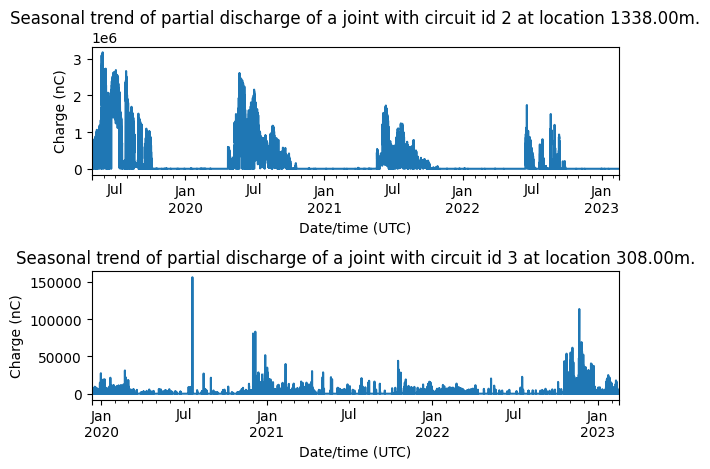

In [7]:
fig, axs = plt.subplots(nrows=len(joints_with_partial_discharge_seasonality))
for idx, (circuit_id, circuit_joint_dict) in enumerate(joints_with_partial_discharge_seasonality.items()):
    circuit_joint_dict["joint"].partial_discharge.plot(ax=axs[idx])
    axs[idx].set_title(
        f"Seasonal trend of partial discharge of a joint with circuit id {circuit_id} at location {circuit_joint_dict['joint'].location:.2f}m.")
    axs[idx].set_ylabel("Charge (nC)")
plt.tight_layout()

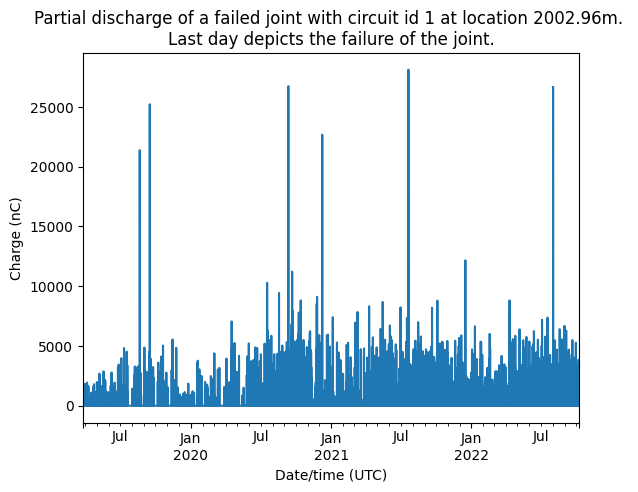

In [8]:
for circuit_id, circuit_joint_dict in failed_joints.items():
    circuit_joint_dict["joint"].partial_discharge.plot()
    plt.title(
        f"Partial discharge of a failed joint with circuit id {circuit_id} at location {circuit_joint_dict['joint'].location:.2f}m. \nLast day depicts the failure of the joint.")
    plt.ylabel("Charge (nC)")